<a href="https://colab.research.google.com/github/vd4mmind/googleColab/blob/ML_scRNASeq_SK_lab_2020/Day5_of_01_Exploratory_data_analysis_with_autoencoder_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis in retinal bipolar data with autoencoders

In this notebook, we will build a neural network that explores the retinal bipolar dataset for Shekhar et al., 2016 without using the manually annotated cell type labels.

## 1. Imports

In [1]:
!pip install scprep

     |████████████████████████████████| 102kB 3.2MB/s 


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scprep

## 2. Loading the retinal bipolar data

We'll use the same retinal bipolar data we used for the classifier.

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have annotated celltype labels yet. Replace all references to `metadata['CELLTYPE']` with an entry from `metadata`, or your favorite gene.

In [0]:
scprep.io.download.download_google_drive("1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf", "data.pickle.gz")
scprep.io.download.download_google_drive("1q1N1s044FGWzYnQEoYMDJOjdWPm_Uone", "metadata.pickle.gz")

In [0]:
data_raw = pd.read_pickle("data.pickle.gz")
metadata = pd.read_pickle("metadata.pickle.gz")

In [0]:
data = scprep.reduce.pca(data_raw, n_components=100, method='dense').to_numpy()
labels, cluster_names = pd.factorize(metadata['CELLTYPE'])

## 3. Building an autoencoder

An **autoencoder** is a network that tries to reproduce its input. 

In this case, we will squeeze the data through a two-dimensional bottleneck (i.e. a extremely low-dimensional hidden layer) which we can use for visualization. Also, reducing the dimension from 100 down to 2 forces the network to only retain the most important information, which intrinsically behaves as a kind of denoising.

#### Create layers


In [0]:
class layer(nn.Module):
    def __init__(self, input_size, output_size, activation=None):
        super(layer, self).__init__()

        self.weight = torch.randn(input_size, output_size).double().requires_grad_()
        self.bias = torch.randn(output_size).double().requires_grad_()
        self.activation = activation

    def forward(self, x):
        output = torch.matmul(x, self.weight) + self.bias
        output = self.activation(output)
        return output

In [0]:
# move data to pytorch tensors
data_tensor = torch.Tensor(data)

### Method 1

In [0]:
# layers will be input -> 100 -> 2 --> 100 -> output
# first hidden layer of size 100
hidden_layer1 = layer(input_size=data_tensor.shape[1], 
                      output_size= 100, 
                      activation=nn.ReLU())

# we won't apply a nonlinear activation to the 2D middle layer
hidden_layer2 = layer(input_size=100, 
                      output_size=2,
                      activation=None)

# last hidden layer of size 100
hidden_layer3 = layer(input_size=2,
                         output_size=100, 
                         activation=nn.ReLU())

# the output should be the same size as the input
output = layer(input_size=100,
              output_size=data_tensor.shape[1], 
               activation=None)

### Method 2

PyTorch provides the linear layers we've been manually defining in its `nn` module (the same place we've been getting our activation functions) as [`nn.Linear()`](https://pytorch.org/docs/stable/nn.html#linear), so let's go ahead and repeat the layer creation step above using this new knowledge.


In [0]:
# layers will be input -> 100 -> 2 --> 100 -> output

# first hidden layer of size 100
hidden_layer1 = nn.Linear(in_features=data_tensor.shape[1], 
                      out_features= 100)

# second middle layer
hidden_layer2 = nn.Linear(in_features=100, 
                      out_features=2)

# last hidden layer of size 100
hidden_layer3 = nn.Linear(in_features=2,
                        out_features=100)

# the output should be the same size as the input
output_layer4 = nn.Linear(in_features=100,
              out_features=data_tensor.shape[1])

As you may have noticed, we did not specify our activation functions this time. Since this is separate from the `nn.Linear` class, we will have to define them outside our layers. 

In [0]:
activation_1 = nn.ReLU()
activation_3 = nn.ReLU()

Now let's use some PyTorch magic and create a model using `nn.Sequential`, which we can just treat as some fancy list for Pytorch layers. One of the benefits of this is that we can use `model.parameters()` to pull out the list of network parameters, rather than having to list them ourselves.

In [0]:
autoencoder1 = nn.Sequential(hidden_layer1,
                            activation_1,
                            hidden_layer2,
                            hidden_layer3,
                            activation_3,
                            output_layer4
                            )

`nn.Sequential` ties together our layers and creates a model. The data passes through the model in the order we place the layers. We can print out the model to see the list of layers.

In [12]:
print(autoencoder1)

Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
  (3): Linear(in_features=2, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
)


#### Define Optimizer

As in the classifier, we'll start with a SGD optimizer.

In [0]:
learning_rate = 0.001

optimizer = optim.SGD(autoencoder1.parameters(),
                       lr=learning_rate)


#### Loss function

Since this is an autoencoder, we don't have prior assumptions on the output (like it being a discrete probability distribution, as it was in classification) so we can't use fancy loss functions like the cross entropy. Instead, we'll just compute the mean squared error of the output compared to the input.

In [0]:
loss_fcn = nn.MSELoss()

#### Train the network

Let's move our hyperparameters to a function that we can reuse to train other models

In [0]:
def train_model(model, n_epochs=10):

    batch_size=100
    learning_rate = 0.001
    optimizer = optim.SGD(model.parameters(),
                        lr=learning_rate)
    loss_fcn = nn.MSELoss()

    # we'll train the network for 10 epochs
    step = 0
    for epoch in range(n_epochs):
        # randomize the order of the data each time through
        random_order = np.random.permutation(data_tensor.shape[0])
        data_randomized = data_tensor[random_order]

        # train the network on batches of size `batch_size`
        for data_batch in np.array_split(data_randomized, data_randomized.shape[0] // batch_size):
            step += 1

            # update the network weights to minimize the loss
            output = model(data_batch)

            # get loss
            loss = loss_fcn(output, data_batch)

            # print the loss every 100 epochs
            if step % 100 == 0:
                print("Step: {} Loss: {:.3f}".format(step, loss.item()))

            # backpropagate the loss
            loss.backward()

            # update parameters
            optimizer.step()

            # reset gradients
            optimizer.zero_grad()

    return model

In [16]:
autoencoder1 = train_model(autoencoder1)

Step: 100 Loss: 11.773
Step: 200 Loss: 11.414
Step: 300 Loss: 11.368
Step: 400 Loss: 12.021
Step: 500 Loss: 11.073
Step: 600 Loss: 11.514
Step: 700 Loss: 11.028
Step: 800 Loss: 10.272
Step: 900 Loss: 9.370
Step: 1000 Loss: 8.581
Step: 1100 Loss: 8.316
Step: 1200 Loss: 8.058
Step: 1300 Loss: 8.022
Step: 1400 Loss: 7.861
Step: 1500 Loss: 8.304
Step: 1600 Loss: 7.583
Step: 1700 Loss: 7.825
Step: 1800 Loss: 7.585
Step: 1900 Loss: 7.712
Step: 2000 Loss: 8.103
Step: 2100 Loss: 7.552


#### Visualize the output

Rather than evaluating our model with our data like we did with the classifier, we can now use our model to evaluate our data (aka exploratory data analysis)!  Autoencoder networks are very useful in exploratory data analysis.

In [17]:
print(autoencoder1[:3])

Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
)


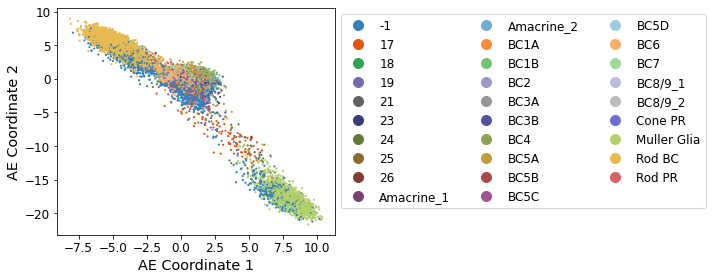

In [18]:
# let's get the 2D internal hidden layer and visualize it with a scatter plot

with torch.no_grad():
    ae_coordinates = autoencoder1[:3](data_tensor).numpy()


scprep.plot.scatter2d(ae_coordinates, c=cluster_names[labels],
                      label_prefix='AE Coordinate ', discrete=True,
                      legend_anchor=(1,1), figsize=(10,4))

### Exercise

Try retraining the network for more than just 10 epochs and plot it again. 

In [19]:
# =======
# Retrain the network
autoencoder1 = train_model(
    autoencoder1,
    n_epochs = 20
)
# =======

Step: 100 Loss: 7.902
Step: 200 Loss: 7.746
Step: 300 Loss: 7.983
Step: 400 Loss: 7.628
Step: 500 Loss: 8.190
Step: 600 Loss: 7.780
Step: 700 Loss: 7.741
Step: 800 Loss: 7.317
Step: 900 Loss: 7.294
Step: 1000 Loss: 7.412
Step: 1100 Loss: 7.321
Step: 1200 Loss: 7.115
Step: 1300 Loss: 7.338
Step: 1400 Loss: 6.841
Step: 1500 Loss: 7.066
Step: 1600 Loss: 7.007
Step: 1700 Loss: 7.075
Step: 1800 Loss: 7.101
Step: 1900 Loss: 7.152
Step: 2000 Loss: 7.361
Step: 2100 Loss: 7.320
Step: 2200 Loss: 7.313
Step: 2300 Loss: 7.084
Step: 2400 Loss: 7.111
Step: 2500 Loss: 7.117
Step: 2600 Loss: 6.592
Step: 2700 Loss: 6.995
Step: 2800 Loss: 7.065
Step: 2900 Loss: 6.524
Step: 3000 Loss: 7.139
Step: 3100 Loss: 6.584
Step: 3200 Loss: 7.141
Step: 3300 Loss: 6.549
Step: 3400 Loss: 7.287
Step: 3500 Loss: 6.224
Step: 3600 Loss: 6.851
Step: 3700 Loss: 6.558
Step: 3800 Loss: 7.054
Step: 3900 Loss: 7.061
Step: 4000 Loss: 7.302
Step: 4100 Loss: 6.784
Step: 4200 Loss: 6.729
Step: 4300 Loss: 6.648


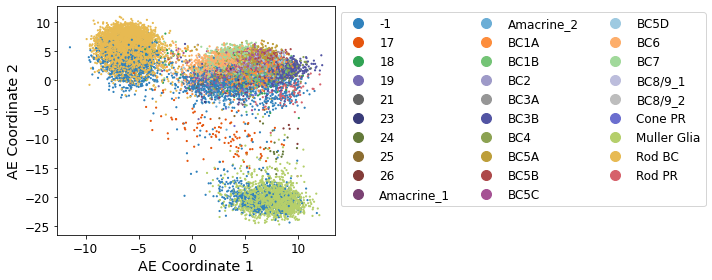

In [20]:
with torch.no_grad():
    ae_coordinates = autoencoder1[:3](data_tensor).numpy()

scprep.plot.scatter2d(ae_coordinates, c=cluster_names[labels],
                      label_prefix='AE Coordinate ', discrete=True,
                      legend_anchor=(1,1), figsize=(10,4))

In [21]:
# =======
# Retrain the network
autoencoder2 = train_model(
    autoencoder1,
    n_epochs = 25 ##trying with 25
)
# =======

Step: 100 Loss: 7.143
Step: 200 Loss: 7.075
Step: 300 Loss: 7.185
Step: 400 Loss: 6.753
Step: 500 Loss: 6.511
Step: 600 Loss: 6.836
Step: 700 Loss: 7.139
Step: 800 Loss: 7.137
Step: 900 Loss: 6.786
Step: 1000 Loss: 6.788
Step: 1100 Loss: 6.497
Step: 1200 Loss: 7.024
Step: 1300 Loss: 6.578
Step: 1400 Loss: 7.108
Step: 1500 Loss: 6.931
Step: 1600 Loss: 6.408
Step: 1700 Loss: 6.878
Step: 1800 Loss: 6.544
Step: 1900 Loss: 6.819
Step: 2000 Loss: 6.895
Step: 2100 Loss: 6.402
Step: 2200 Loss: 6.814
Step: 2300 Loss: 6.847
Step: 2400 Loss: 6.859
Step: 2500 Loss: 6.859
Step: 2600 Loss: 6.602
Step: 2700 Loss: 6.939
Step: 2800 Loss: 6.168
Step: 2900 Loss: 6.453
Step: 3000 Loss: 6.661
Step: 3100 Loss: 6.557
Step: 3200 Loss: 6.740
Step: 3300 Loss: 6.491
Step: 3400 Loss: 6.510
Step: 3500 Loss: 6.411
Step: 3600 Loss: 6.665
Step: 3700 Loss: 6.827
Step: 3800 Loss: 6.820
Step: 3900 Loss: 7.110
Step: 4000 Loss: 6.617
Step: 4100 Loss: 6.420
Step: 4200 Loss: 6.780
Step: 4300 Loss: 6.473
Step: 4400 Loss: 6.5

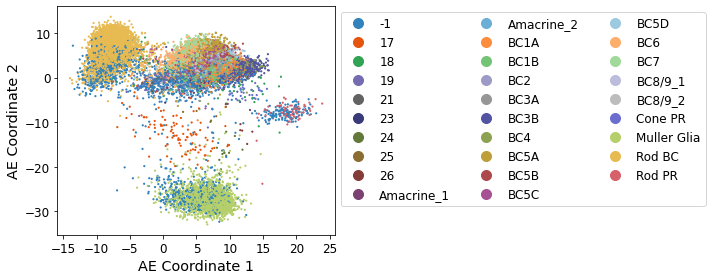

In [22]:
with torch.no_grad():
    ae_coordinates = autoencoder1[:3](data_tensor).numpy()

scprep.plot.scatter2d(ae_coordinates, c=cluster_names[labels],
                      label_prefix='AE Coordinate ', discrete=True,
                      legend_anchor=(1,1), figsize=(10,4))

### Discussion

1. What do you notice about the visualization? 
2. How does this compare to the visualizations you have seen with PCA, t-SNE, UMAP and PHATE?

## Exercise 4 - Activation functions on the visualization layer

Notice we did not use an acitvation function for the hidden layer we were going to visualize.

Repeat the process with other activation functions like `nn.ReLU`, `nn.Sigmoid`, `nn.Tanh`, etc. You can see more in the [PyTorch activation function documentions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). 

Note how the visualization changes. Has the data changed at all?

In [0]:
# ======
# choose from nn.Sigmoid(), nn.Tanh() and others in the documentation
activation_2 = nn.Tanh()
# ======

autoencoder2 = nn.Sequential(hidden_layer1,
                            activation_1,
                            hidden_layer2,
                            activation_2,
                            hidden_layer3,
                            activation_3,
                            output_layer4
                            )

In [24]:
autoencoder2 = train_model(autoencoder2)

Step: 100 Loss: 11.176
Step: 200 Loss: 9.993
Step: 300 Loss: 10.389
Step: 400 Loss: 10.413
Step: 500 Loss: 10.668
Step: 600 Loss: 9.433
Step: 700 Loss: 9.451
Step: 800 Loss: 9.542
Step: 900 Loss: 10.754
Step: 1000 Loss: 10.424
Step: 1100 Loss: 10.639
Step: 1200 Loss: 9.304
Step: 1300 Loss: 9.797
Step: 1400 Loss: 9.627
Step: 1500 Loss: 9.665
Step: 1600 Loss: 8.662
Step: 1700 Loss: 9.601
Step: 1800 Loss: 9.891
Step: 1900 Loss: 9.393
Step: 2000 Loss: 8.203
Step: 2100 Loss: 9.659


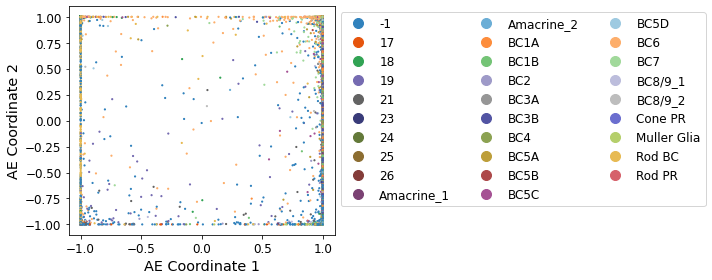

In [25]:
# let's get the 2D internal hidden layer and visualize it with a scatter plot

with torch.no_grad():
    ae_coordinates2 = autoencoder2[:4](data_tensor).numpy()

scprep.plot.scatter2d(ae_coordinates2, c=cluster_names[labels],
                      label_prefix='AE Coordinate ', discrete=True,
                      legend_anchor=(1,1), figsize=(10,4))

## Exercise 5 - Activation functions on the wide hidden layers

Now turn the activation for the visualization layer back to None, but experiment with the activation function for the 100-dimensional layers.

Is there a change? Why?

In [0]:
# ======
# choose from nn.Sigmoid(), nn.Tanh() and others in the documentation
activation_1 = nn.Sigmoid()
activation_3 = nn.Sigmoid()
# ======

autoencoder3 = nn.Sequential(hidden_layer1,
                            activation_1,
                            hidden_layer2,
                            hidden_layer3,
                            activation_3,
                            output_layer4
                            )

In [27]:
autoencoder3 = train_model(autoencoder3)

Step: 100 Loss: 9.501
Step: 200 Loss: 9.447
Step: 300 Loss: 9.428
Step: 400 Loss: 10.035
Step: 500 Loss: 9.816
Step: 600 Loss: 9.590
Step: 700 Loss: 9.633
Step: 800 Loss: 10.347
Step: 900 Loss: 9.548
Step: 1000 Loss: 9.657
Step: 1100 Loss: 9.126
Step: 1200 Loss: 9.318
Step: 1300 Loss: 9.278
Step: 1400 Loss: 8.804
Step: 1500 Loss: 8.947
Step: 1600 Loss: 8.762
Step: 1700 Loss: 8.661
Step: 1800 Loss: 8.384
Step: 1900 Loss: 8.836
Step: 2000 Loss: 8.812
Step: 2100 Loss: 8.301


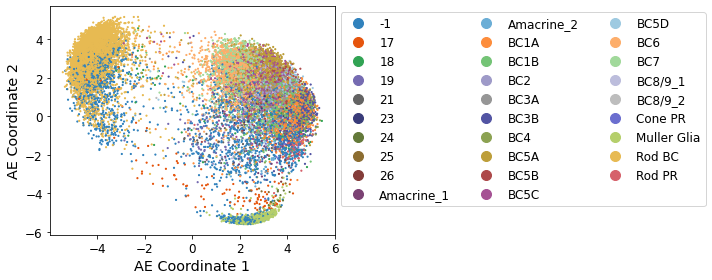

In [28]:
# let's get the 2D internal hidden layer and visualize it with a scatter plot

with torch.no_grad():
    ae_coordinates3 = autoencoder3[:3](data_tensor).numpy()

scprep.plot.scatter2d(ae_coordinates3, c=cluster_names[labels],
                      label_prefix='AE Coordinate ', discrete=True,
                      legend_anchor=(1,1), figsize=(10,4))